## News Sentiment

# Manage API Key & Use NewsApiClient
I've saved my API key in a config file, I've loaded the file and saved my key to a variable.

In [248]:
import config

APIKEY=config.APIKEY

from newsapi import NewsApiClient
newsapi = NewsApiClient(api_key=APIKEY)

# What are the available sources?
I've created a loop to gather all the available sources and save into a dataframe. For clarity sake I've printed the available sources as well as the categories.

In [249]:
import pandas as pd
sources = newsapi.get_sources()
print('How many total sources are available?:',len(sources['sources']))
total_sources = len(sources['sources'])
sources['sources'][0]

id=pd.Series(name='id')
name=pd.Series(name='name')
description=pd.Series(name='description')
url=pd.Series(name='url')
category=pd.Series(name='category')
language=pd.Series(name='language')
country=pd.Series(name='country')
#column_names = ['id', 'name', 'description', 'url', 'category', 'language', 'country']

for idx,outlet in enumerate(sources['sources']):
    id[idx]=outlet['id']
    name[idx] = outlet['name']
    description[idx] = outlet['description']
    url[idx] = outlet['url']
    category[idx] = outlet['category']
    language[idx] = outlet['language']
    country[idx] = outlet['country']
sourcedf=pd.concat([id,name,description,url,category,language,country],axis=1)

print('What are the categories? ', sourcedf['category'].unique())

How many total sources are available?: 128
What are the categories?  ['general' 'business' 'technology' 'sports' 'entertainment' 'health'
 'science']


# Filter the available sources
Requirements: English Language, US Country

In [250]:
sourcedf= sourcedf[(sourcedf['language']=='en') & (sourcedf['country']=='us')]
sourcedf.head()

,id,name,description,url,category,language,country
0,abc-news,ABC News,"Your trusted source for breaking news, analysi...",https://abcnews.go.com,general,en,us
3,al-jazeera-english,Al Jazeera English,"News, analysis from the Middle East and worldw...",http://www.aljazeera.com,general,en,us
6,ars-technica,Ars Technica,The PC enthusiast's resource. Power users and ...,http://arstechnica.com,technology,en,us
8,associated-press,Associated Press,The AP delivers in-depth coverage on the inter...,https://apnews.com/,general,en,us
10,axios,Axios,Axios are a new media company delivering vital...,https://www.axios.com,general,en,us


# What are the business sources?
First we isolate the business sources based on the category variable.
I've displayed the number of business sources as a sanity check, as well as tested that the indexing was working correctly.

In [251]:
business_sources = sourcedf[sourcedf['category']=='business']
business_sources = business_sources.reset_index()
display(business_sources)
print('Number of sources: ',len(business_sources))
#business_sources['id'][0]

,index,id,name,description,url,category,language,country
0,16,bloomberg,Bloomberg,"Bloomberg delivers business and markets news, ...",http://www.bloomberg.com,business,en,us
1,18,business-insider,Business Insider,Business Insider is a fast-growing business si...,http://www.businessinsider.com,business,en,us
2,36,fortune,Fortune,Fortune 500 Daily and Breaking Business News,http://fortune.com,business,en,us
3,117,the-wall-street-journal,The Wall Street Journal,WSJ online coverage of breaking news and curre...,http://www.wsj.com,business,en,us


Number of sources:  4


# Get 30 Days Ago Date in the Proper Format
For the loop below to work (on the free tier) we need to only check back 30 days. We will use the datetime package to get todays date and 30 days prior.

In [252]:
# Get 30 Days Ago
import datetime
from datetime import date, timedelta
print('Todays Date: ', date.today().isoformat())
print('30 Days Ago: ', (date.today()-timedelta(days=30)).isoformat())
startdate=(date.today()-timedelta(days=30)).isoformat()

Todays Date:  2023-09-12
30 Days Ago:  2023-08-13


# Loop through all articles 
There are two layers to this loop, the outer layer loops through the number of business sources (4), while the inner loop gets all the articles from that business source and collects the data.


In [253]:
# Init Variables
Source=pd.Series(name='source')
author=pd.Series(name='author')
title=pd.Series(name='title')
description=pd.Series(name='description')
url=pd.Series(name='url')
publishedAt=pd.Series(name='publishedAt')
content=pd.Series(name='content')
# Use Counter
counter=0
# Loop through each source 
for source in business_sources['id']:
    news_articles = newsapi.get_everything(q='apple',
                                          sources=source,
                                          from_param=startdate,
                                          )
    # Gather data from each article
    for idx, article in enumerate(news_articles['articles']):
        Source[counter] = article['source']['id']
        author[counter] = article['author']
        title[counter] = article['title']
        description[counter] = article['description']
        url[counter] = article['url']
        publishedAt[counter] = article['publishedAt']
        content[counter] = article['content']
        #author=pd.concat([Source,article['author']],axis=1)
        #for details in article:
        #    print(details['title'])
        counter = counter + 1
# Combine 
all_articles = pd.concat([Source, author, title, description, url, publishedAt, content],axis=1)
all_articles.head()

pd.set_option('display.max_columns',None)

# Sentiment Analysis
The time has finally come for the namesake of this workbook... Sentiment Analysis.

Textblob is a simple python library for sentiment analysis that provides both an integer for sentiment and one for subjectivity based on a lexicon of coded words. I think subjectivity would be a useful variable for this analysis, but TextBlob does not enable the use of phrases.

We will also use Vader, another python library for sentiment analysis trained on social media that provides a score for positive, negative, neutral, and a  composite.

In [254]:
from textblob import TextBlob

text = all_articles['title'][8]
blob = TextBlob(text)
sentiment = blob.sentiment

print(sentiment)

Sentiment(polarity=0.0, subjectivity=0.0)


In [255]:
TitlePolarity = pd.Series(name='TitlePolarity')
TitleSubjectivity = pd.Series(name='TitleSubjectivity')
TitleNegative = pd.Series(name='TitleNegative')
TitleNeutral = pd.Series(name='TitleNeutral')
TitlePositive = pd.Series(name='TitlePositive')
TitleComposite = pd.Series(name='TitleComposite')
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

id = 0
for title in all_articles['title']:
    #print(id,title)
    blob = TextBlob(title)
    sentiment = blob.sentiment
    TitlePolarity[id] = sentiment.polarity
    TitleSubjectivity[id] = sentiment.subjectivity

    vs = analyzer.polarity_scores(title)
    TitleNegative[id] = vs['neg']
    TitleNeutral[id] = vs['neu']
    TitlePositive[id] = vs['pos']
    TitleComposite[id] = vs['compound']

    id=id+1

all_articles = pd.concat([all_articles, TitlePolarity, TitleSubjectivity, TitleNegative, TitleNeutral, TitlePositive, TitleComposite],axis=1)
all_articles.head()

,source,author,title,description,url,publishedAt,content,TitlePolarity,TitleSubjectivity,TitleNegative,TitleNeutral,TitlePositive,TitleComposite
0,business-insider,Lakshmi Varanasi,Apple is reportedly working on the Watch's big...,Apple is planning to release a new model of th...,https://www.businessinsider.com/apple-working-...,2023-08-14T16:03:56Z,Apple has a major redesign of the Apple Watch ...,0.000000,0.000000,0.000,1.000,0.000,0.0000
1,business-insider,htan@insider.com (Huileng Tan),The billionaire founder of a key Apple supplie...,He said no foreign investor would dare invest ...,https://www.businessinsider.com/foxconn-terry-...,2023-08-28T10:21:20Z,"Terry Gou, the billionaire founder of Foxconn ...",0.000000,1.000000,0.000,0.870,0.130,0.4374
2,business-insider,Theron Mohamed,4 Big Tech giants have plowed over $1 trillion...,Apple poured over $600 billion into buybacks i...,https://markets.businessinsider.com/news/stock...,2023-08-30T10:39:42Z,Apple CEO Tim Cook.Richard Drew/AP Images\r\n<...,0.166667,0.408333,0.000,0.906,0.094,0.3400
3,business-insider,Pete Syme,"Apple, Amazon, and Meta among 6 tech giants de...","The European Union named Alphabet, Amazon, App...",https://www.businessinsider.com/tiktok-and-met...,2023-09-06T11:55:50Z,"Google, Apple, Facebook, Amazon, and Microsoft...",0.136364,0.454545,0.000,0.918,0.082,0.1779
4,business-insider,Huileng Tan,Fears about China's government ban on iPhones ...,Apple shares have shed about $200 million in m...,https://www.businessinsider.com/iphone-china-g...,2023-09-11T04:41:41Z,"An Apple Store in Shanghai, China.CFOTO/Future...",0.000000,1.000000,0.225,0.775,0.000,-0.7506


In [256]:
descriptionPolarity = pd.Series(name='descriptionPolarity')
descriptionSubjectivity = pd.Series(name='descriptionSubjectivity')
descriptionNegative = pd.Series(name='descriptionNegative')
descriptionNeutral = pd.Series(name='descriptionNeutral')
descriptionPositive = pd.Series(name='descriptionPositive')
descriptionComposite = pd.Series(name='descriptionComposite')
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

id = 0
for description in all_articles['description']:
    #print(id,description)
    blob = TextBlob(description)
    sentiment = blob.sentiment
    descriptionPolarity[id] = sentiment.polarity
    descriptionSubjectivity[id] = sentiment.subjectivity

    vs = analyzer.polarity_scores(description)
    descriptionNegative[id] = vs['neg']
    descriptionNeutral[id] = vs['neu']
    descriptionPositive[id] = vs['pos']
    descriptionComposite[id] = vs['compound']

    id=id+1

all_articles = pd.concat([all_articles, descriptionPolarity, descriptionSubjectivity, descriptionNegative, descriptionNeutral, descriptionPositive, descriptionComposite],axis=1)
all_articles.head()

,source,author,title,description,url,publishedAt,content,TitlePolarity,TitleSubjectivity,TitleNegative,TitleNeutral,TitlePositive,TitleComposite,descriptionPolarity,descriptionSubjectivity,descriptionNegative,descriptionNeutral,descriptionPositive,descriptionComposite
0,business-insider,Lakshmi Varanasi,Apple is reportedly working on the Watch's big...,Apple is planning to release a new model of th...,https://www.businessinsider.com/apple-working-...,2023-08-14T16:03:56Z,Apple has a major redesign of the Apple Watch ...,0.000000,0.000000,0.000,1.000,0.000,0.0000,0.136364,0.454545,0.000,1.000,0.000,0.0000
1,business-insider,htan@insider.com (Huileng Tan),The billionaire founder of a key Apple supplie...,He said no foreign investor would dare invest ...,https://www.businessinsider.com/foxconn-terry-...,2023-08-28T10:21:20Z,"Terry Gou, the billionaire founder of Foxconn ...",0.000000,1.000000,0.000,0.870,0.130,0.4374,0.031250,0.562500,0.123,0.782,0.095,-0.1280
2,business-insider,Theron Mohamed,4 Big Tech giants have plowed over $1 trillion...,Apple poured over $600 billion into buybacks i...,https://markets.businessinsider.com/news/stock...,2023-08-30T10:39:42Z,Apple CEO Tim Cook.Richard Drew/AP Images\r\n<...,0.166667,0.408333,0.000,0.906,0.094,0.3400,0.000000,0.000000,0.000,1.000,0.000,0.0000
3,business-insider,Pete Syme,"Apple, Amazon, and Meta among 6 tech giants de...","The European Union named Alphabet, Amazon, App...",https://www.businessinsider.com/tiktok-and-met...,2023-09-06T11:55:50Z,"Google, Apple, Facebook, Amazon, and Microsoft...",0.136364,0.454545,0.000,0.918,0.082,0.1779,0.000000,0.000000,0.105,0.818,0.077,-0.1531
4,business-insider,Huileng Tan,Fears about China's government ban on iPhones ...,Apple shares have shed about $200 million in m...,https://www.businessinsider.com/iphone-china-g...,2023-09-11T04:41:41Z,"An Apple Store in Shanghai, China.CFOTO/Future...",0.000000,1.000000,0.225,0.775,0.000,-0.7506,0.000000,0.066667,0.260,0.650,0.089,-0.6369


# Convert Date Variable 
The format for the publishedAt variable is down to the nanosecond, we just need the date since we're predicting daily data.


In [257]:
all_articles['Date']= pd.to_datetime(all_articles['publishedAt']).dt.floor('H')

all_articles['Date']

0     2023-08-14 16:00:00+00:00
1     2023-08-28 10:00:00+00:00
2     2023-08-30 10:00:00+00:00
3     2023-09-06 11:00:00+00:00
4     2023-09-11 04:00:00+00:00
                 ...           
144   2023-08-23 15:00:00+00:00
145   2023-08-30 11:00:00+00:00
146   2023-08-31 09:00:00+00:00
147   2023-09-08 11:00:00+00:00
148   2023-09-06 10:00:00+00:00
Name: Date, Length: 149, dtype: datetime64[ns, UTC]

# Download Stock Data

In [258]:
import yfinance as yf
import numpy as np
sdf=yf.download('aapl',start=startdate, interval="1h")
sdf=sdf.reset_index()
sdf = sdf.rename(columns={'Datetime':'Date'})
sdf['Date'] = sdf['Date'].dt.floor('H')
# Subset just Date & Close
sdf=sdf[['Date','Close']]
sdf['Return'] = np.where(sdf['Close'] > sdf['Close'].shift(1),1,0)

sdf.head()

[*********************100%***********************]  1 of 1 completed


,Date,Close,Return
0,2023-08-14 09:00:00-04:00,178.270004,0
1,2023-08-14 10:00:00-04:00,179.350006,1
2,2023-08-14 11:00:00-04:00,178.714493,0
3,2023-08-14 12:00:00-04:00,179.227905,1
4,2023-08-14 13:00:00-04:00,179.089996,0


In [259]:
#Merge
combineddf= pd.merge(sdf,all_articles,how='left').ffill(limit=24)
combineddf['SMA12']= combineddf['Close'].rolling(12).mean()
combineddf['SMA24']= combineddf['Close'].rolling(24).mean()
combineddf['SMA48']= combineddf['Close'].rolling(48).mean()
# Drop all unnecessary data
combineddf = combineddf.drop(columns=['author','title','description','source','url','publishedAt','content'])
combineddf.tail(10)

,Date,Close,Return,TitlePolarity,TitleSubjectivity,TitleNegative,TitleNeutral,TitlePositive,TitleComposite,descriptionPolarity,descriptionSubjectivity,descriptionNegative,descriptionNeutral,descriptionPositive,descriptionComposite,SMA12,SMA24,SMA48
148,2023-09-11 13:00:00-04:00,179.514999,1,0.291667,0.791667,0.0,1.000,0.000,0.0000,1.0,0.3,0.00,0.856,0.144,0.6369,178.966417,179.147299,183.884189
149,2023-09-11 14:00:00-04:00,179.695007,1,0.000000,0.000000,0.0,0.909,0.091,0.2023,0.0,1.0,0.12,0.880,0.000,-0.5267,178.980584,179.000825,183.711585
150,2023-09-11 15:00:00-04:00,179.380005,0,0.000000,0.000000,0.0,0.909,0.091,0.2023,0.0,1.0,0.12,0.880,0.000,-0.5267,178.944602,178.853516,183.529085
151,2023-09-12 09:00:00-04:00,177.550003,0,0.000000,0.000000,0.0,0.909,0.091,0.2023,0.0,1.0,0.12,0.880,0.000,-0.5267,178.777519,178.641671,183.298981
152,2023-09-12 10:00:00-04:00,176.699997,0,0.000000,0.000000,0.0,0.909,0.091,0.2023,0.0,1.0,0.12,0.880,0.000,-0.5267,178.537102,178.440837,183.044604
153,2023-09-12 11:00:00-04:00,176.604996,0,0.000000,0.000000,0.0,0.909,0.091,0.2023,0.0,1.0,0.12,0.880,0.000,-0.5267,178.347501,178.178962,182.809917
154,2023-09-12 12:00:00-04:00,177.569901,1,0.000000,0.000000,0.0,0.909,0.091,0.2023,0.0,1.0,0.12,0.880,0.000,-0.5267,178.316242,178.241875,182.565956
155,2023-09-12 13:00:00-04:00,176.100006,0,0.000000,0.000000,0.0,0.909,0.091,0.2023,0.0,1.0,0.12,0.880,0.000,-0.5267,178.142076,178.190975,182.304290
156,2023-09-12 14:00:00-04:00,175.720001,0,0.000000,0.000000,0.0,0.909,0.091,0.2023,0.0,1.0,0.12,0.880,0.000,-0.5267,177.961243,178.126809,182.025227
157,2023-09-12 15:00:00-04:00,176.300003,1,0.000000,0.000000,0.0,0.909,0.091,0.2023,0.0,1.0,0.12,0.880,0.000,-0.5267,177.757076,178.115080,181.758248


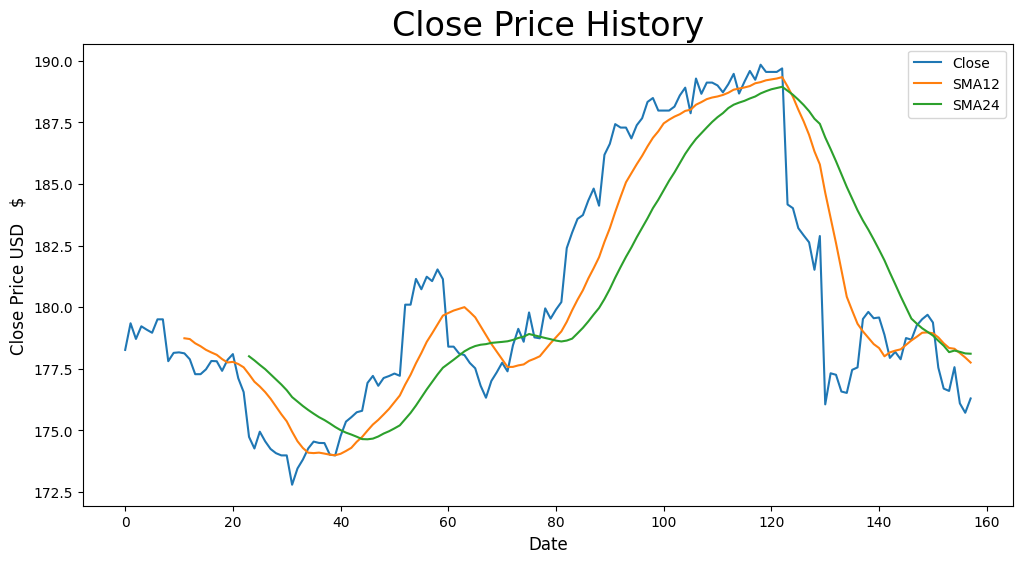

In [260]:
import matplotlib.pyplot as plt
# Visualize the Closing price
plt.figure(figsize=(12,6))# specifies size
plt.title('Close Price History',fontsize=24)
plt.plot(combineddf[['Close','SMA12','SMA24']])
plt.xlabel('Date',fontsize=12)
plt.ylabel('Close Price USD   $',fontsize=12)
plt.legend(['Close','SMA12','SMA24'])
plt.show()

In [261]:
# missing data
combineddf= combineddf.dropna(axis=0)

# Split Data into training & testing

In [262]:
# How many days did the stock go up and down?
combineddf['Return'].value_counts()

Return
1    56
0    55
Name: count, dtype: int64

In [263]:
from sklearn.model_selection import train_test_split
X = combineddf.drop(columns=['Return','Date'])
Y = combineddf[['Return']]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.33, random_state = 0)


In [264]:
from sklearn.preprocessing import StandardScaler

ss_train = StandardScaler()
X_train = ss_train.fit_transform(X_train)

ss_test = StandardScaler()
X_test = ss_test.fit_transform(X_test)

In [265]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=1000, max_depth=5)

In [266]:
# Get predictions
model.fit(X_train, Y_train.values.ravel())
preds = model.predict(X_test)

In [267]:
from sklearn.metrics import accuracy_score

accuracy_score(Y_test,preds)

0.5405405405405406

In [268]:
from sklearn.linear_model import LogisticRegression
model2 = LogisticRegression()
model2.fit(X_train, Y_train.values.ravel())
preds2 = model.predict(X_test)
accuracy_score(Y_test,preds2)
#preds2

0.5405405405405406

# LSTM

In [270]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import math

stock = combineddf[['Close']]
dataset = stock.values
training_data_len = math.ceil(len(dataset)*.8)
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))

scaled_data = scaler.fit_transform(dataset)
# Create the training dataset
train_data = scaled_data[0:training_data_len,:]

x_train=[]# dependent
y_train=[]# outcome
# Loop systematically takes 60 days as x training and the output being the next day
for i in range(60,len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])
  if i<=61:
    print('x_train :',i,x_train)
    print('y_train',y_train)
    print()

# Convert x & y training to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

x_train= np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

x_train : 60 [array([0.07748593, 0.09985865, 0.1055245 , 0.11260601, 0.10623233,
       0.31055213, 0.31055213, 0.38456052, 0.3548156 , 0.39093528,
       0.37818684, 0.41182751, 0.38385269, 0.18994281, 0.18994281,
       0.17032575, 0.16571569, 0.14305984, 0.12776214, 0.07790414,
       0.04320119, 0.09135933, 0.11614731, 0.14376767, 0.11897321,
       0.19334254, 0.24114731, 0.20396642, 0.28824316, 0.21658627,
       0.21388788, 0.29992933, 0.27049563, 0.29638803, 0.31798917,
       0.47308746, 0.51770539, 0.55701191, 0.56798917, 0.60978011,
       0.64412212, 0.59490062, 0.74114731, 0.77266342, 0.82931979,
       0.81941239, 0.81941239, 0.78824424, 0.82613295, 0.84631736,
       0.89305984, 0.90439155, 0.86827187, 0.86827187, 0.86827187,
       0.87960357, 0.91182751, 0.93414296, 0.86048145, 0.9603401 ])]
y_train [0.9164310847144055]

x_train : 61 [array([0.07748593, 0.09985865, 0.1055245 , 0.11260601, 0.10623233,
       0.31055213, 0.31055213, 0.38456052, 0.3548156 , 0.39093528,
  

(29, 60, 1)

In [271]:
# Build the lstm
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (x_train.shape[1], 1 ))) # 50 neurons
model.add(LSTM(50,return_sequences=False)) # False because its the last lstm layer
model.add(Dense(25))# Neural network layer with 25 neurons
model.add(Dense(1))# neural network layer with 1 neuron

In [272]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [273]:
# Train the model
model.fit(x_train, y_train, batch_size=1, epochs= 1)

29/29 [==============================] - 7s 28ms/step - loss: 0.1370


In [274]:
# Create the test dataset
test_data = scaled_data[training_data_len-60:,:]
x_test = []
y_test = dataset[training_data_len:,:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i,0])

In [275]:
x_test = np.array(x_test)

In [276]:
# Reshape
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
x_test.shape

(22, 60, 1)

In [277]:
# Get the model's predicted price values
predictions = model.predict(x_test)

# Inverse transform the data back to the regular prices
predictions = scaler.inverse_transform(predictions)

1/1 [==============================] - 2s 2s/step


C:\Users\ddg12\AppData\Local\Temp\ipykernel_26612\2700723874.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


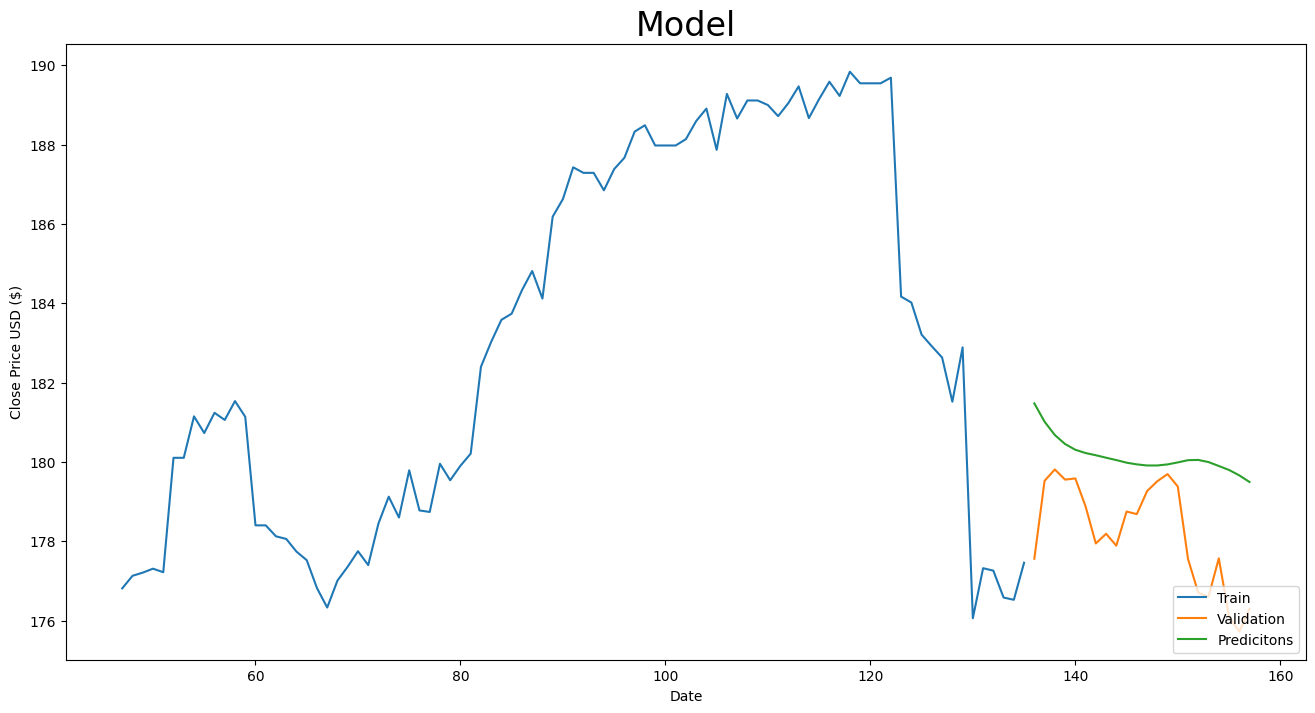

In [278]:
# Visualize the data
train = stock[0:training_data_len]
valid = stock[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model',fontsize=24)
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train','Validation','Predicitons'],loc='lower right')
plt.show()